In [28]:
#!pip install yellowbrick

In [63]:
# imporation des librairies
import pandas as pd
import sqlite3
from datetime import date, datetime as dt

import dateutil.parser

from time import time
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_digits
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [30]:
# connection à la BDD
conn = sqlite3.connect("database/e-commerce.db")
cur = conn.cursor()

In [31]:
# récupération des dates pour la Recence pour chaque client unique
sql_recence = """ SELECT c.unique_id, o.purchase_timestamp  
                FROM order_dataset o
                JOIN customer c ON c.id = o.customer_id               
                GROUP BY unique_id 
                """

recence = cur.execute(sql_recence).fetchall()

In [32]:
# récupération des scores (votes) pour chaque client unique
sql_score = """ SELECT c.unique_id, r.score
                FROM order_review r
                JOIN order_dataset o ON o.order_id = r.order_id 
                JOIN customer c ON c.id = o.customer_id                          
                GROUP BY unique_id 
                ORDER BY r.score DESC """

score = cur.execute(sql_score).fetchall()

In [33]:
# récupération total commande pour chaque client unique
sql_nb_order = """ SELECT c.unique_id, COUNT(o.order_id) AS nb_commande 
                FROM order_dataset o
                JOIN customer c ON c.id = o.customer_id               
                GROUP BY unique_id 
                ORDER BY nb_commande DESC"""

nb_order = cur.execute(sql_nb_order).fetchall()

In [34]:
# récupération des achats totatux pour chaque client unique
sql_montant = """ SELECT SUM(p.value) as total, c.unique_id 
                FROM order_paiement p
                JOIN order_dataset o ON o.order_id = p.order_id 
                JOIN customer c ON c.id = o.customer_id                          
                GROUP BY unique_id 
                ORDER BY total DESC
                """
montant = cur.execute(sql_montant).fetchall()

In [35]:
# transformation des listes en dataframe
df_montant = pd.DataFrame(montant)
df_score = pd.DataFrame(score)
df_nb_order = pd.DataFrame(nb_order)
df_recence = pd.DataFrame(recence)

# on renomme les colonnes de chaque dataframe
df_score.columns= ["unique_id_customer",'score']
df_nb_order.columns= ["unique_id_customer",'nb_order']
df_montant.columns = ["total_buy","unique_id_customer"]
df_recence.columns = ["unique_id_customer", "order_date"]

# nombre de jour de la dernière commande à aujourd'hui
today = "2018-12-31"
df_recence["order_date"] = pd.to_datetime(df_recence["order_date"])
df_recence["last_date"] = pd.to_datetime(today)
df_recence["nb_day"] = (df_recence["last_date"] - df_recence["order_date"]).dt.days
print(df_recence)

#fusion des dataframes
df_cluster = pd.merge(df_montant,df_score)
df_cluster = df_cluster.merge(df_nb_order, how = "inner")
df_cluster = df_cluster.merge(df_recence, how = "inner")
df_cluster['nb_order'] = df_cluster['nb_order'].fillna(0)
df_cluster['score'] = df_cluster['score'].fillna(0)
df_cluster = df_cluster[["nb_order","total_buy","score", "nb_day"]]
df_cluster


                     unique_id_customer          order_date  last_date  nb_day
0      0000366f3b9a7992bf8c76cfdf3221e2 2018-05-10 10:56:27 2018-12-31     234
1      0000b849f77a49e4a4ce2b2a4ca5be3f 2018-05-07 11:11:27 2018-12-31     237
2      0000f46a3911fa3c0805444483337064 2017-03-10 21:05:03 2018-12-31     660
3      0000f6ccb0745a6a4b88665a16c9f078 2017-10-12 20:29:41 2018-12-31     444
4      0004aac84e0df4da2b147fca70cf8255 2017-11-14 19:45:42 2018-12-31     411
...                                 ...                 ...        ...     ...
96091  fffcf5a5ff07b0908bd4e2dbc735a684 2017-06-08 21:00:36 2018-12-31     570
96092  fffea47cd6d3cc0a88bd621562a9d061 2017-12-10 20:07:56 2018-12-31     385
96093  ffff371b4d645b6ecea244b27531430a 2017-02-07 15:49:16 2018-12-31     691
96094  ffff5962728ec6157033ef9805bacc48 2018-05-02 15:17:41 2018-12-31     242
96095  ffffd2657e2aad2907e67c3e9daecbeb 2017-05-02 20:18:45 2018-12-31     607

[96096 rows x 4 columns]


,nb_order,total_buy,score,nb_day
0,1,13664.08,1,457
1,3,9553.02,1,145
2,2,7571.63,5,638
3,1,7274.88,1,168
4,1,6929.31,5,686
...,...,...,...,...
95374,1,10.89,3,192
95375,1,10.07,5,473
95376,1,9.59,5,127
95377,1,0.00,3,118


In [36]:
# mise à l’échelle des données
scaled_df = StandardScaler().fit_transform(df_cluster)
scaled_df

array([[-0.16270931, 58.62822434, -2.28955803,  0.61005769],
       [ 9.14127832, 40.77157865, -2.28955803, -1.42049685],
       [ 4.4892845 , 32.16528753,  0.67909709,  1.78803965],
       ...,
       [-0.16270931, -0.68090517,  0.67909709, -1.53764423],
       [-0.16270931, -0.72255994, -0.80523047, -1.59621792],
       [-0.16270931, -0.72255994, -2.28955803, -1.55716879]])

KElbowVisualizer(ax=<AxesSubplot:>, estimator=KMeans(n_clusters=11), k=(2, 12))

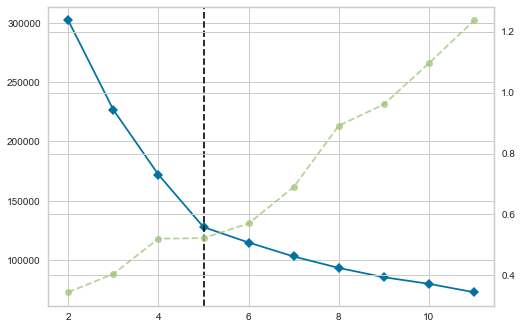

In [37]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

model = KMeans()

visualizer = KElbowVisualizer(model, k=(2,12))
visualizer.fit(scaled_df) 

KElbowVisualizer(ax=<AxesSubplot:>, estimator=KMeans(n_clusters=11), k=(2, 12),
                 metric='calinski_harabasz')

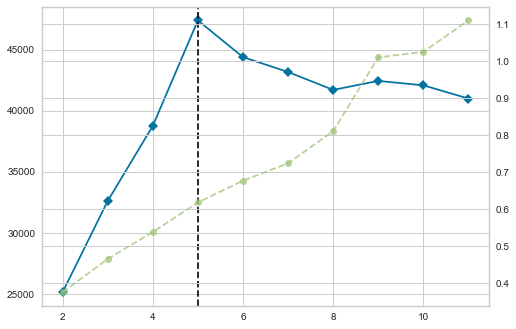

In [38]:
visualizer = KElbowVisualizer(model, k=(2,12), metric='calinski_harabasz')
visualizer.fit(scaled_df) 

In [39]:
# le metric silhouette prend trop de temps à charger
#visualizer = KElbowVisualizer(model, k=(2,12), metric='silhouette')
#visualizer.fit(df_cluster) 

[6.91807774e-01 3.08151536e-01 2.93652585e-05]


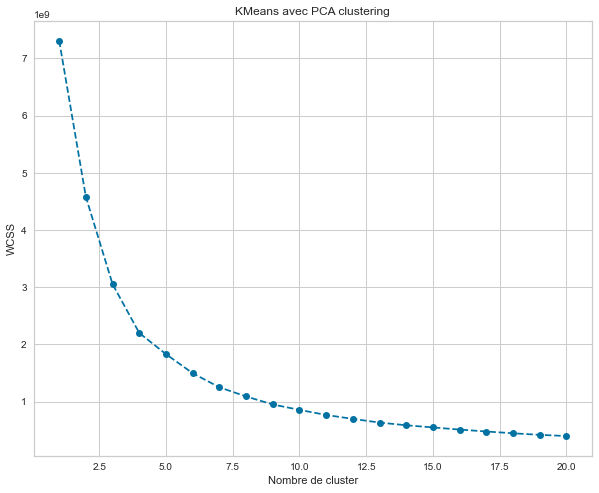

In [58]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca.fit(df_cluster)
print(pca.explained_variance_ratio_)
score_pca = pca.transform(df_cluster)

wcss = []
for i in range (1, 21):
    kmeans_pca = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans_pca.fit(score_pca)
    wcss.append(kmeans_pca.inertia_)
    
plt.figure(figsize=(10,8))
plt.plot(range(1, 21), wcss, marker = 'o', linestyle = '--')
plt.xlabel('Nombre de cluster')
plt.ylabel('WCSS')
plt.title('KMeans avec PCA clustering')
plt.show()

In [74]:
kmeans_pca = KMeans(n_clusters=5, init='k-means++', random_state=42)
kmeans_pca.fit(score_pca)
df_seg_pca_kmeans = pd.concat([df_cluster.reset_index(drop = True ), pd.DataFrame(score_pca)], axis = 1)
df_seg_pca_kmeans.columns.values[-3:] = ['Component 1', 'Component 2', 'Component 3']
df_seg_pca_kmeans['Segment K-Means PCA'] = kmeans_pca.labels_
df_seg_pca_kmeans

,nb_order,total_buy,score,nb_day,cluster,Component 1,Component 2,Component 3,Segment K-Means PCA
0,1,13664.08,1,457,2,13497.974836,46.079244,0.956455,3
1,3,9553.02,1,145,2,9385.839753,-251.397938,0.546811,3
2,2,7571.63,5,638,2,7406.201006,248.584283,-0.905825,3
3,1,7274.88,1,168,2,7107.795033,-220.355215,0.915104,3
4,1,6929.31,5,686,2,6764.054346,298.850853,-0.672694,3
...,...,...,...,...,...,...,...,...,...
95374,1,10.89,3,192,1,-156.065296,-170.715657,0.910269,0
95375,1,10.07,5,473,4,-155.893492,110.298248,-1.501803,4
95376,1,9.59,5,127,1,-157.595270,-235.709837,-0.964729,0
95377,1,0.00,3,118,1,-167.216409,-244.675325,0.670413,0


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


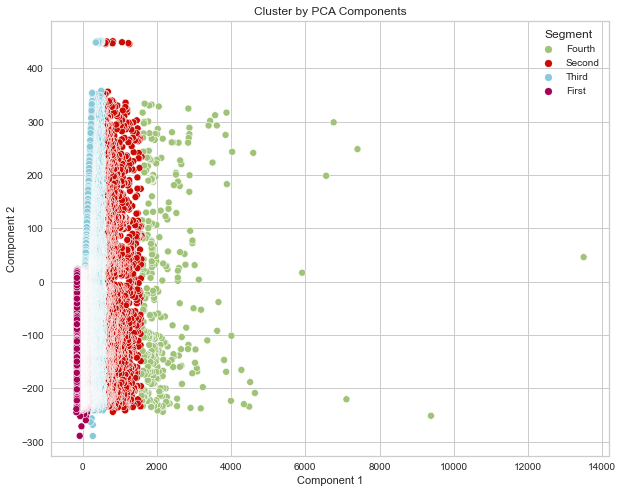

In [75]:
df_seg_pca_kmeans['Segment'] = df_seg_pca_kmeans['Segment K-Means PCA'].map({
    0: 'First',
    1: 'Second',
    2: 'Third',
    3: 'Fourth'
})

x_axis = df_seg_pca_kmeans['Component 1']
y_axis = df_seg_pca_kmeans['Component 2']
plt.figure(figsize=(10,8))
sns.scatterplot(x_axis, y_axis, hue = df_seg_pca_kmeans['Segment'], palette = ['g', 'r', 'c', 'm'])
plt.title('Cluster by PCA Components')
plt.show()

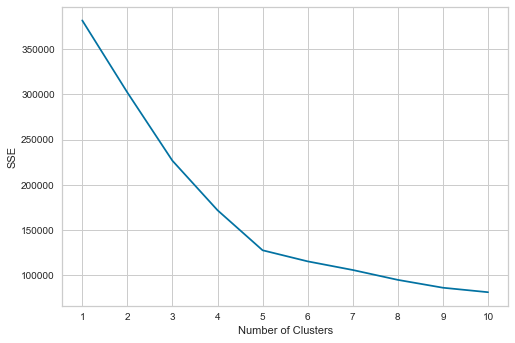

In [41]:
#initialize kmeans parameters
kmeans_kwargs = {
"init": "random",
"n_init": 10,
"random_state": 1,
}

#create list to hold SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_df)
    sse.append(kmeans.inertia_)

#visualize results
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [42]:
kmeans = KMeans(init="random", n_clusters=5, n_init=10, random_state=1)

#fit k-means algorithm to data
kmeans.fit(scaled_df)

#view cluster assignments for each observation
kmeans.labels_

df_cluster['cluster'] = kmeans.labels_

#view updated DataFrame
df_cluster

,nb_order,total_buy,score,nb_day,cluster
0,1,13664.08,1,457,4
1,3,9553.02,1,145,4
2,2,7571.63,5,638,4
3,1,7274.88,1,168,4
4,1,6929.31,5,686,4
...,...,...,...,...,...
95374,1,10.89,3,192,1
95375,1,10.07,5,473,3
95376,1,9.59,5,127,1
95377,1,0.00,3,118,1


In [76]:
# moyenne des achats
moyenne_buy = df_cluster.groupby(["cluster"])["total_buy"].mean().reset_index()

# moyenne du nombre de commande
moyenne_purchase = df_cluster.groupby(["cluster"])["nb_order"].mean().reset_index()

# moyenne des étoiles
moyenne_score = df_cluster.groupby(["cluster"])["score"].mean().reset_index()

# répartition des clusters en nombre et pourcentage
nb_clients = df_cluster.groupby(["cluster"])['score'].count().reset_index()
nb_clients.columns = ['cluster', 'count']
nb_clients['percent'] = (100*nb_clients['count']) / nb_clients['count'].sum()

# moyenne des nombres de jour des dernières commandes
moyenne_days = df_cluster.groupby(["cluster"])["nb_day"].mean().reset_index()

In [77]:
df_graph = pd.merge(moyenne_score,moyenne_purchase).merge(moyenne_buy).merge(nb_clients).merge(moyenne_days)
#df_graph = pd.merge(df_graph,moyenne_buy)
df_graph

,cluster,score,nb_order,total_buy,count,percent,nb_day
0,0,2.641780,1.476326,265.481206,5639,5.912203,467.759532
1,1,3.924847,1.000000,132.003333,55766,58.467797,265.707976
2,2,4.100977,3.117264,867.764104,307,0.321874,393.530945
3,3,3.961538,1.000000,1239.995315,2002,2.098995,360.201798
4,4,4.631644,1.000000,134.509996,31665,33.199132,516.360682


In [49]:
import altair as alt
alt.data_transformers.enable('default', max_rows=None)
source = nb_clients

alt.Chart(source).mark_arc().encode(
    theta=alt.Theta(field="count", type="quantitative"),
    color=alt.Color(field="cluster", type="nominal"),
)

alt.Chart(...)

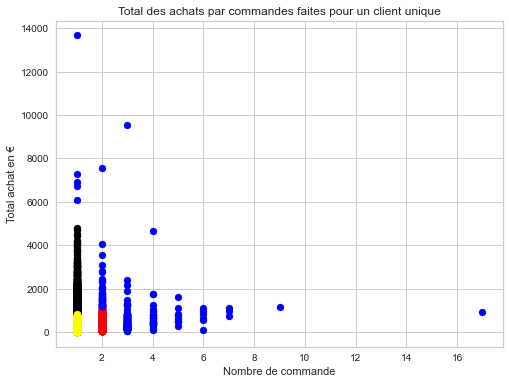

In [50]:
from sklearn.mixture import GaussianMixture
from matplotlib import pyplot as plt
n_clusters = 5
gmm_model = GaussianMixture(n_components=n_clusters)
gmm_model.fit(df_cluster)

plt.figure(figsize=(8,6))

cluster_labels = gmm_model.predict(df_cluster)
X = df_cluster
X['cluster'] = cluster_labels
color = np.array(['Red','green','blue', 'Black', 'yellow'])

for k in range(0,n_clusters):
    data = X[X["cluster"]==k]
    plt.scatter(data["nb_order"],data["total_buy"],c=color[k])


plt.title("Total des achats par commandes faites pour un client unique")    
plt.ylabel("Total achat en €")
plt.xlabel("Nombre de commande")
plt.show()

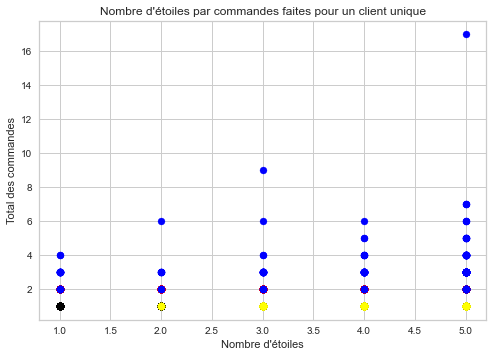

In [51]:
for k in range(0,n_clusters):
    data = X[X["cluster"]==k]
    plt.scatter(data["score"],data["nb_order"],c=color[k])


plt.title("Nombre d'étoiles par commandes faites pour un client unique")    
plt.ylabel("Total des commandes")
plt.xlabel("Nombre d'étoiles")
plt.show()

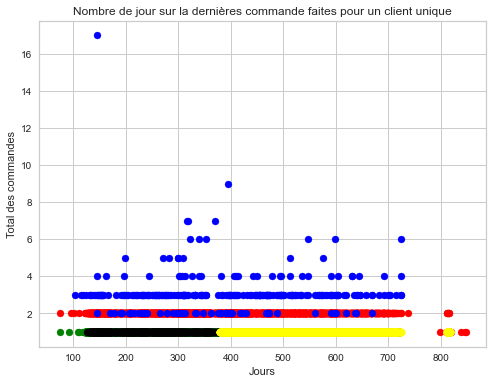

In [52]:
plt.figure(figsize=(8,6))
for k in range(0,n_clusters):
    data = X[X["cluster"]==k]
    plt.scatter(data["nb_day"],data["nb_order"],c=color[k])


plt.title("Nombre de jour sur la dernières commande faites pour un client unique")    
plt.ylabel("Total des commandes")
plt.xlabel("Jours")
plt.show()